In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import random
import numpy as np

# Load data

In [4]:
file_path = 'names_v2.txt'
# https://www.kaggle.com/datasets/kaggle/us-baby-names?select=NationalNames.csv
words = open(file_path, 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
char_to_idx = {char: idx+1 for idx, char in enumerate(chars)}
char_to_idx['.'] = 0
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
vocab_size = len(idx_to_char)

print(f'{idx_to_char=}\n{vocab_size=}')

idx_to_char={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab_size=27


# Create dataloader

In [5]:
def build_dataset(words, char_to_idx, context_size=3):
  X, Y = [], []

  for w in words:
    context = [0] * context_size
    for char in w + '.':
      idx = char_to_idx[char]
      X.append(context)
      Y.append(idx)
      context = context[1:] + [idx]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(f'{X.shape=}, {Y.shape=}')
  return X, Y

In [48]:
context_size = 6
train_size = 0.80

random.seed(42)
random.shuffle(words)
split = int(train_size * len(words))
X_train, y_train = build_dataset(words[:split], char_to_idx, context_size=context_size)
X_valid, y_valid = build_dataset(words[split:], char_to_idx, context_size=context_size)

X.shape=torch.Size([565657, 6]), Y.shape=torch.Size([565657])
X.shape=torch.Size([141540, 6]), Y.shape=torch.Size([141540])


# Model architecture

In [81]:
emb_size = 64
hidden_size = 256

generator = torch.Generator().manual_seed(2147483647)
char_emb = torch.randn((vocab_size, emb_size), generator=generator)
# Layer 1
W1 = torch.randn((emb_size * context_size, hidden_size), generator=generator) * (5/3)/((emb_size * context_size)**0.5)
b1 = torch.randn(hidden_size, generator=generator) * 0.1
# Layer 2
W2 = torch.randn((hidden_size, vocab_size), generator=generator) * 0.1
b2 = torch.randn(vocab_size, generator=generator) * 0.1
# Batch Norm
batch_norm_scale = torch.randn((1, hidden_size)) * 0.1 + 1.0
batch_norm_shift = torch.randn((1, hidden_size)) * 0.1

parameters = [char_emb, W1, b1, W2, b2, batch_norm_scale, batch_norm_shift]
print(f'# of params: {sum(param.nelement() for param in parameters):,}')

# of params: 107,739


In [82]:
for param in parameters:
    param.requires_grad = True

max_steps = 200000
batch_size = 32
n = batch_size
lossi = []

with torch.no_grad():
  for step in range(max_steps):

    # mini batch embedding
    mini_batch = torch.randint(0, X_train.shape[0], (batch_size, ), generator=generator) # (batch_size)
    X_batch, y_batch = X_train[mini_batch], y_train[mini_batch] # (batch_size, context_size) (batch_size)

    # forward pass
    emb = char_emb[X_batch] # emb: (batch_size, context_size, emb_size)  char_emb: (vocab_size, emb_size)
    flatten_emb = emb.view(emb.shape[0], -1) # (batch_size, context_size*emb_size)
    # Linear layer 1
    pre_batch_norm = flatten_emb @ W1 + b1 # (batch_size, hidden_size) = (batch_size, context_size*emb_size) @ (context_size*emb_size, hidden_size)
    # Batch Norm 1
    batch_norm_mean = pre_batch_norm.mean(0, keepdim=True) # (1, hidden_size)
    batch_norm_var = pre_batch_norm.var(0, keepdim=True, unbiased=True) # (1, hidden_size)
    batch_norm_var_inv = (batch_norm_var + 1e-5)**-0.5 # (1, hidden_size)
    batch_norm_raw = (pre_batch_norm - batch_norm_mean) * batch_norm_var_inv # (batch_size, hidden_size)
    Z = batch_norm_scale * batch_norm_raw + batch_norm_shift # (batch_size, hidden_size)
    # Activation 1
    A = torch.tanh(Z) # (batch_size, hidden_size)
    # Linear layer 2
    logits = A @ W2 + b2 # (batch_size, vocab_size) = (batch_size, hidden_size) @ (hidden_size, vocab_size) + (vocab_size)

    # Loss
    loss = F.cross_entropy(logits, y_batch)

    # backward pass
    for param in parameters:
      param.grad = None
    d_logits = F.softmax(logits, 1)
    d_logits[range(n), y_batch] -= 1
    d_logits /= n # (batch_size, vocab_size)
    # Layer 2
    d_A = d_logits @ W2.T # (batch_size, hidden_size) = (batch_size, vocab_size) @ (vocab_size, hidden_size)
    d_W2 = A.T @ d_logits # (hidden_size, vocab_size) = (hidden_size, batch_size) @ (batch_size, vocab_size)
    d_b2 = d_logits.sum(0) # (vocab_size)
    d_Z = (1.0 - A) * d_A # (batch_size, hidden_size)
    # Batch norm
    d_batch_norm_scale = (batch_norm_raw * d_Z).sum(0, keepdim=True) # (1, hidden_size)
    d_batch_norm_shift = d_Z.sum(0, keepdim=True) # (1, hidden_size)
    d_pre_batch_norm = batch_norm_scale * batch_norm_var_inv/n * (n*d_Z - d_Z.sum(0) - n/(n-1)*batch_norm_raw*(d_Z*batch_norm_raw).sum(0)) # (batch_size, hidden_size)
    # Layer 1
    d_flatten_emb = d_pre_batch_norm @ W1.T # (batch_size, emb_size*context_size) = (batch_size, hidden_size) @ (hidden_size, emb_size*context_size)
    d_W1 = flatten_emb.T @ d_pre_batch_norm # (emb_size*context_size, hidden_size) = (emb_size*context_size, batch_size) @ (batch_size, hidden_size)
    d_b1 = d_pre_batch_norm.sum(0) # (hidden_size)
    # mini batch embedding
    d_emb = d_flatten_emb.view(emb.shape) # (batch_size, context_size, emb_size)
    d_char_emb = torch.zeros_like(char_emb) # (vocab_size, emb_size)
    for k in range(X_batch.shape[0]):
      for j in range(X_batch.shape[1]):
        idx = X_batch[k, j]
        d_char_emb[idx] += d_emb[k, j]

    grads = [d_char_emb, d_W1, d_b1, d_W2, d_b2, d_batch_norm_scale, d_batch_norm_shift]

    lr = 0.05 if step < 100000 else 0.001
    for param, grad in zip(parameters, grads):
      param.data += -lr * grad

    if step % 10000 == 0:
      print(f'({step}/{max_steps}) {loss.item():.5f}')

    lossi.append(loss.log10().item())


(0/200000) 3.43349
(10000/200000) 2.32297
(20000/200000) 2.10526
(30000/200000) 2.79503
(40000/200000) 2.15389
(50000/200000) 2.15833
(60000/200000) 2.28641
(70000/200000) 2.22962
(80000/200000) 2.02574
(90000/200000) 2.13992
(100000/200000) 1.86943
(110000/200000) 2.16934
(120000/200000) 1.83136
(130000/200000) 2.25810
(140000/200000) 2.09214
(150000/200000) 2.33142
(160000/200000) 2.05065
(170000/200000) 2.08573
(180000/200000) 2.06263
(190000/200000) 2.05408


# Plot loss

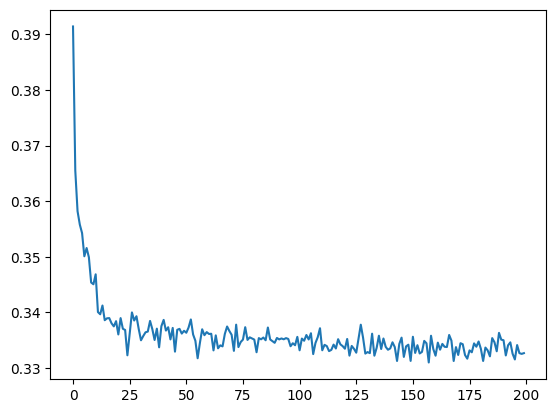

In [83]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [84]:
# calibrate the batch norm at the end of training
with torch.no_grad():
  emb = char_emb[X_train]
  flatten_emb = emb.view(emb.shape[0], -1)
  Z = flatten_emb @ W1 + b1
  batch_norm_mean = Z.mean(0, keepdim=True)
  batch_norm_var = Z.var(0, keepdim=True, unbiased=True)

In [85]:
@torch.no_grad()
def split_loss(split):
  X, y = {
      'train': (X_train, y_train),
      'valid': (X_valid, y_valid)
  }[split]
  emb = char_emb[X]
  flatten_emb = emb.view(emb.shape[0], -1)
  Z = flatten_emb @ W1 + b1
  Z = batch_norm_scale * (Z - batch_norm_mean) * (batch_norm_var + 1e-5)**-0.5 + batch_norm_shift
  A = torch.tanh(Z)
  logits = A @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('valid')

train 2.13602614402771
valid 2.141263246536255


# Generate names

In [86]:
generator = torch.Generator()

with torch.no_grad():
  for _ in range(50):

    out = []
    context = [0] * context_size
    while True:
      emb = char_emb[torch.tensor([context])]
      flatten_emb = emb.view(emb.shape[0], -1)
      Z = flatten_emb @ W1 + b1
      Z = batch_norm_scale * (Z - batch_norm_mean) * (batch_norm_var + 1e-5)**-0.5 + batch_norm_shift
      A = torch.tanh(Z)
      logits = A @ W2 + b2

      # sample
      probs = F.softmax(logits, dim=1)
      idx = torch.multinomial(probs, num_samples=1, generator=generator).item()
      context = context[1:] + [idx]
      out.append(idx)
      if idx == 0:
        break

    print(''.join(idx_to_char[i] for i in out))

cybinteefhi.
lyndyea.
tumiaa.
ertaicra.
melutie.
zlica.
jatanna.
kaiaber.
lianna.
tavon.
sanibara.
bredancy.
evaanis.
chana.
daline.
aniva.
catashna.
gunnie.
rantyus.
caudreona.
tylere.
jonixan.
colhen.
colonn.
safen.
geerica.
aereksaa.
romcia.
dalino.
jackiyauga.
malisya.
kemsa.
cofene.
jahnady.
vayana.
jomnoreles.
ayanna.
don.
kalis.
zusian.
armardy.
alteika.
delin.
daline.
kait.
dilylina.
donella.
lynnie.
jasquion.
nahnaha.
